# 1. Set up Environment

In [2]:
%pwd

'/home/jovyan/work/notebooks'

In [3]:
%cd '/home/jovyan/work'

/home/jovyan/work


In [4]:
%load_ext autoreload
%autoreload 2

In [68]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
pd.options.display.max_rows = 10000

# 2. Load and Explore Data

In [7]:
df = pd.read_csv('data_files/raw/beer_reviews.csv')

In [8]:
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [9]:
df.shape

(1586614, 13)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
brewery_id            1586614 non-null int64
brewery_name          1586599 non-null object
review_time           1586614 non-null int64
review_overall        1586614 non-null float64
review_aroma          1586614 non-null float64
review_appearance     1586614 non-null float64
review_profilename    1586266 non-null object
beer_style            1586614 non-null object
review_palate         1586614 non-null float64
review_taste          1586614 non-null float64
beer_name             1586614 non-null object
beer_abv              1518829 non-null float64
beer_beerid           1586614 non-null int64
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


In [11]:
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


# 3. Prepare Data

In [12]:
df_cleaned = df.copy()

### Drop unused variables

In [13]:
df_cleaned = df_cleaned.drop(['brewery_id', 'review_time','review_profilename','beer_beerid','beer_name','beer_abv'], axis=1)

### Create Categorical Variable Dictionary

In [14]:
arr_brewery_name = df_cleaned.brewery_name.unique()
arr_beer_style = df_cleaned.beer_style.unique()

In [15]:
lst_brewery_name = list(arr_brewery_name)
lst_beer_style = list(arr_beer_style)

In [16]:
cats_dict = {
    'brewery_name': [lst_brewery_name],
    'beer_style': [lst_beer_style]
}

### Quantify NULL Values

In [17]:
df_cleaned.isnull().sum()

brewery_name         15
review_overall        0
review_aroma          0
review_appearance     0
beer_style            0
review_palate         0
review_taste          0
dtype: int64

In [18]:
df_cleaned.dropna(how='any', inplace=True)

### Transform Categorical column values with encoder

In [19]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [20]:
for col, cats in cats_dict.items():
    col_encoder = OrdinalEncoder(categories=cats)
    df_cleaned[col] = col_encoder.fit_transform(df_cleaned[[col]])

In [21]:
num_cols = ['brewery_name','review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste']

In [22]:
target_col = 'beer_style'

In [23]:
sc = StandardScaler()

In [24]:
df_cleaned[num_cols] = sc.fit_transform(df_cleaned[num_cols])

In [25]:
df_cleaned['beer_style'] = df_cleaned['beer_style'].astype(int)

In [64]:
X = df_cleaned

In [65]:
y = df_cleaned['beer_style']

### Visualise Target Class Distribution

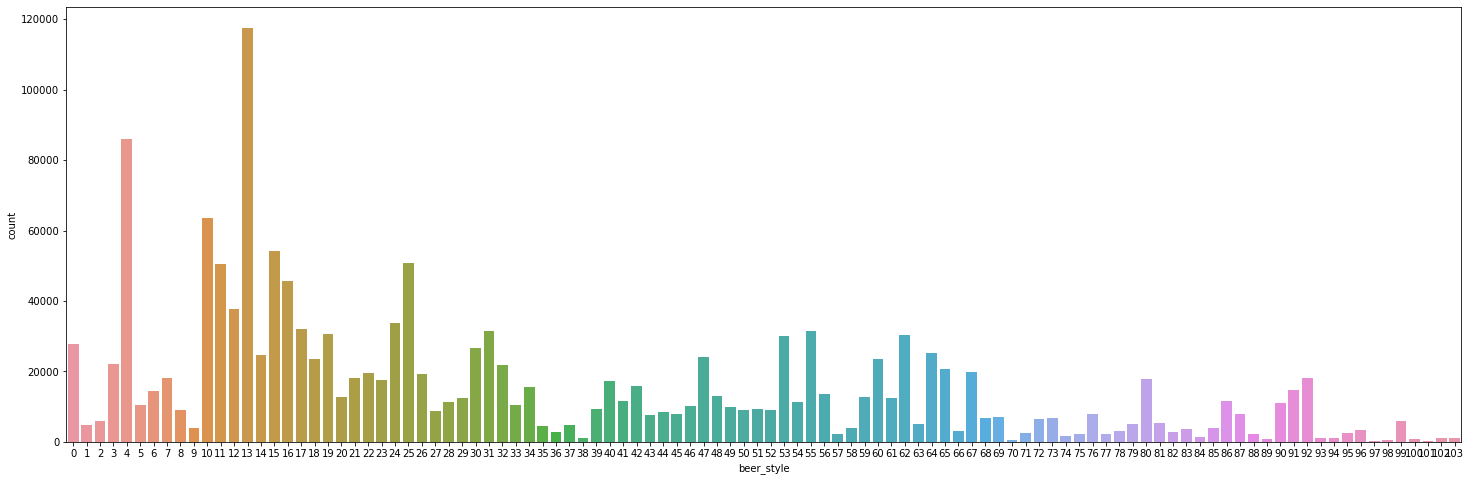

In [66]:
a4_dims = (25, 8)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.countplot(ax=ax,x = 'beer_style', data=X)

### Split Data

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

ValueError: could not determine the shape of object type 'DataFrame'

,brewery_name,review_overall,review_aroma,review_appearance,beer_style,review_palate,review_taste
1189259,0.840909,0.255913,-1.054506,1.068599,81,0.375682,-0.400107
1026982,0.501280,-1.131783,1.812409,1.880169,42,-0.357227,-1.083199
845512,0.058443,1.643609,1.095680,1.068599,39,1.841500,0.966078
69652,-1.549693,0.255913,-0.337777,0.257029,0,0.375682,-0.400107
804524,-0.028564,0.255913,-0.337777,-0.554541,60,-0.357227,0.282985
...,...,...,...,...,...,...,...
259178,-1.078053,-1.825631,-2.487964,-2.989252,85,-1.090136,-1.766291
1414429,1.401356,0.255913,-1.054506,-0.554541,65,-0.357227,-0.400107
131932,-1.361877,0.255913,0.378951,0.257029,15,0.375682,-0.400107
671164,-0.310588,0.255913,1.095680,0.257029,16,1.108591,0.282985
